# Loan Approval Prediction Project
Team: Shailja Somani, Verity Pierson, & Mirna Philip\
Dataset Used: Demographic and loan information for select loan applicants, along with if they were approved or not. Retreived from Kaggle at: https://www.kaggle.com/datasets/mirzahasnine/loan-data-set?resource=download\ \
Project Github: https://github.com/shailja-somani-0/loan-approval-pred

## Import and Clean Dataset

In [1]:
# Import packages necessary
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.naive_bayes import MultinomialNB
import statsmodels.api as sm
import statsmodels.tools.tools as stattools

# Hide warnings at end after making sure everything runs as expected for cleanliness
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check working directory if necessary - commented out as not necessary
#os.getcwd()

In [3]:
# Importing the csv file 
loan_df = pd.read_csv('loan_train.csv', header=0, sep=',')
loan_df.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


In [4]:
# Checking to see what the data looks like
loan_df.describe()

,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History
count,6.140000e+02,6.140000e+02,6.140000e+02,600.00000,564.000000
mean,5.403459e+05,1.621246e+05,1.414104e+07,342.00000,0.842199
std,6.109042e+05,2.926248e+05,8.815682e+06,65.12041,0.364878
min,1.500000e+04,0.000000e+00,0.000000e+00,12.00000,0.000000
25%,2.877500e+05,0.000000e+00,9.800000e+06,360.00000,1.000000
50%,3.812500e+05,1.188500e+05,1.250000e+07,360.00000,1.000000
75%,5.795000e+05,2.297250e+05,1.647500e+07,360.00000,1.000000
max,8.100000e+06,4.166700e+06,7.000000e+07,480.00000,1.000000


In [5]:
# Drop all rows with null values
loan_df = loan_df.dropna()
loan_df.shape

(499, 12)

In [6]:
# One-hot encode Area, which has 3 possible answers
loan_encoded = pd.get_dummies(loan_df, columns=['Area'], drop_first=False)

# Encode binary features & target variable to 1 and 0 - use drop_first to have only one column per variable
loan_encoded = pd.get_dummies(loan_encoded, columns=['Gender', 'Married', 'Education', 'Self_Employed','Status'], drop_first=True)

# Convert 3+ in Dependents to just 3 so it's numerical
loan_encoded['Dependents'] = loan_encoded['Dependents'].replace('3+', '3')
loan_encoded['Dependents'] = loan_encoded['Dependents'].astype(int)

loan_encoded.head()

,Dependents,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area_Rural,Area_Semiurban,Area_Urban,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Status_Y
0,0,584900,0.0,15000000,360.0,1.0,0,0,1,1,0,0,0,1
1,1,458300,150800.0,12800000,360.0,1.0,1,0,0,1,1,0,0,0
2,0,300000,0.0,6600000,360.0,1.0,0,0,1,1,1,0,1,1
3,0,258300,235800.0,12000000,360.0,1.0,0,0,1,1,1,1,0,1
4,0,600000,0.0,14100000,360.0,1.0,0,0,1,1,0,0,0,1


In [7]:
# Split data into X & y and train and test datasets - set a random_state to ensure repeatability
X = loan_encoded.drop('Status_Y', axis=1)
y = loan_encoded[['Status_Y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# print the shapes of the resulting splits
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (349, 13)
X_test shape: (150, 13)
y_train shape: (349, 1)
y_test shape: (150, 1)


## EDA

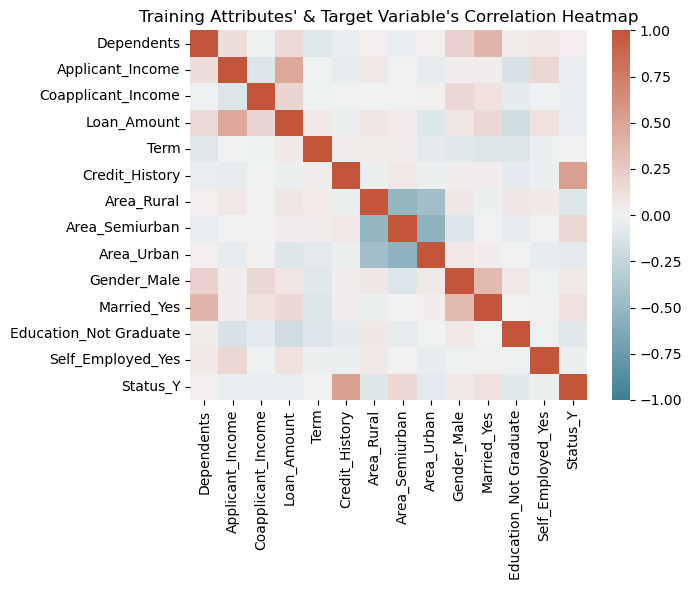

In [141]:
# Create a heatmap to show correlations between all training attributes & target variable (status)
# Get the correlation matrix 
correlation_matrix = loan_encoded.corr()

# create heatmap, set hues for negative, positive areas of map and saturation amount.
# create heatmap given: dataset, value range to anchor map with (-1 and 1), colormap name set above, set title
red_blue = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(correlation_matrix, vmin = -1, vmax = 1, cmap=red_blue).set(title="Training Attributes' & Target Variable's Correlation Heatmap")
plt.show()

In [142]:
loan_encoded['Gender_Male'].value_counts()

1    411
0     88
Name: Gender_Male, dtype: int64

In [21]:
df = loan_encoded.rename(columns={'Gender_Male': 'Gender', 'Married_Yes': 'Married', 'Education_Not Graduate': 'Education', 'Self_Employed_Yes': 'Self_Employed', 'Status_Y': "Status"}, inplace=True)

In [144]:
loan_encoded.head()

,Dependents,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area_Rural,Area_Semiurban,Area_Urban,Gender,Married,Education,Self_Employed,Status
0,0,584900,0.0,15000000,360.0,1.0,0,0,1,1,0,0,0,1
1,1,458300,150800.0,12800000,360.0,1.0,1,0,0,1,1,0,0,0
2,0,300000,0.0,6600000,360.0,1.0,0,0,1,1,1,0,1,1
3,0,258300,235800.0,12000000,360.0,1.0,0,0,1,1,1,1,0,1
4,0,600000,0.0,14100000,360.0,1.0,0,0,1,1,0,0,0,1


In [22]:
crosstab_01 = pd.crosstab(loan_encoded['Gender'], loan_encoded['Credit_History'])

<AxesSubplot:xlabel='Gender'>

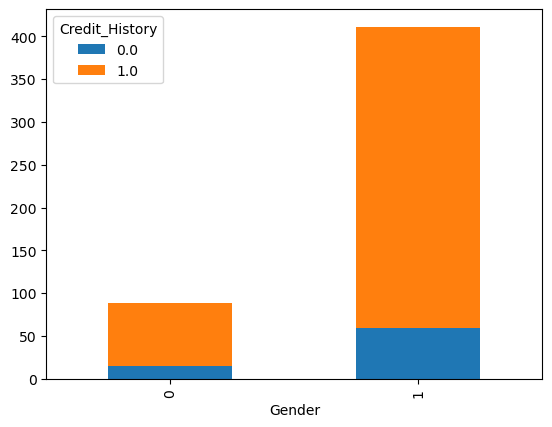

In [23]:
crosstab_01.plot(kind='bar', stacked = True)

In [147]:
crosstab_02 = pd.crosstab(loan_encoded['Gender'], loan_encoded['Status'])

<AxesSubplot:xlabel='Gender'>

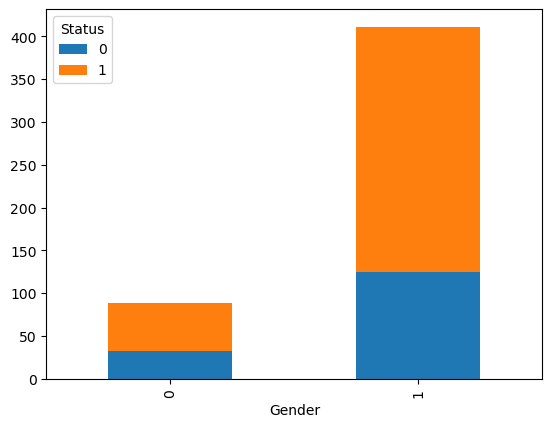

In [148]:
crosstab_02.plot(kind='bar', stacked = True)

In [149]:
crosstab_03 = pd.crosstab(loan_encoded['Education'], loan_encoded['Status'])

<AxesSubplot:xlabel='Education'>

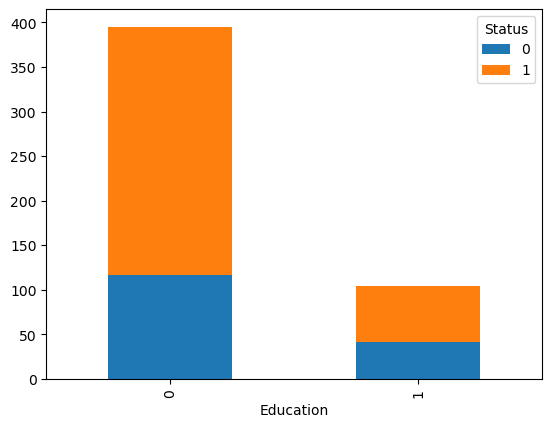

In [150]:
crosstab_03.plot(kind= "bar", stacked = True)

### Review the Original Dataset


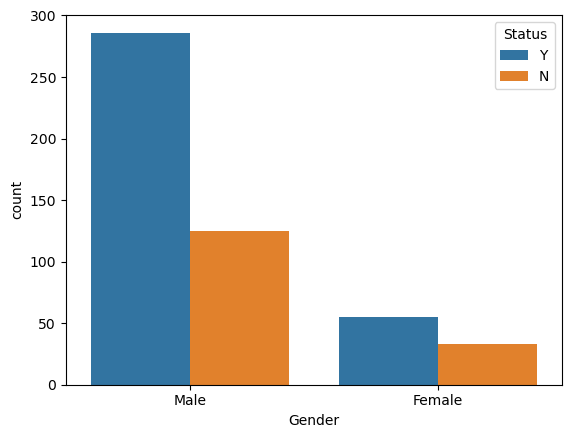

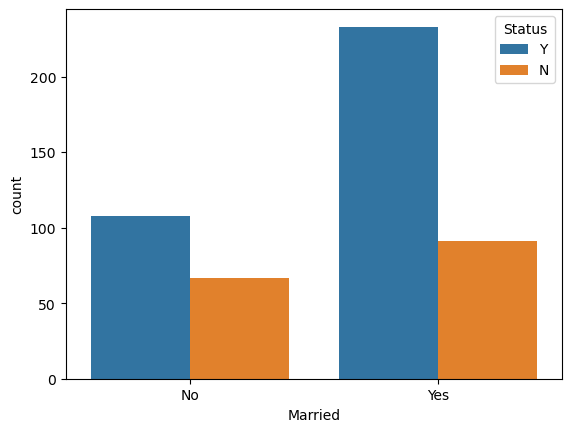

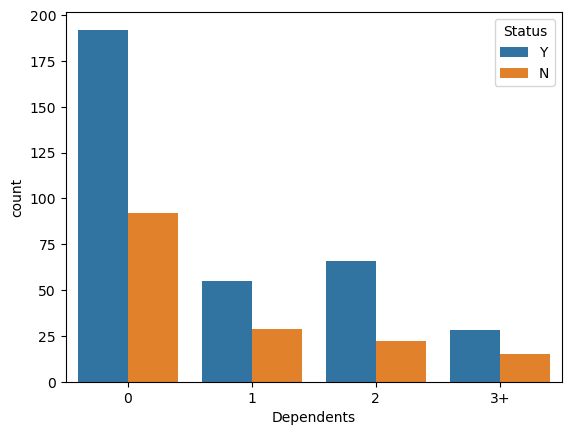

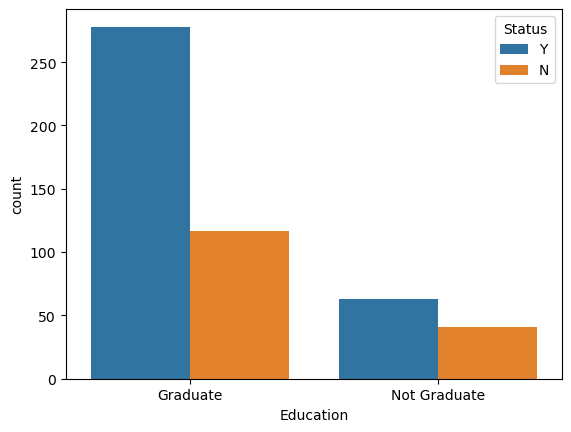

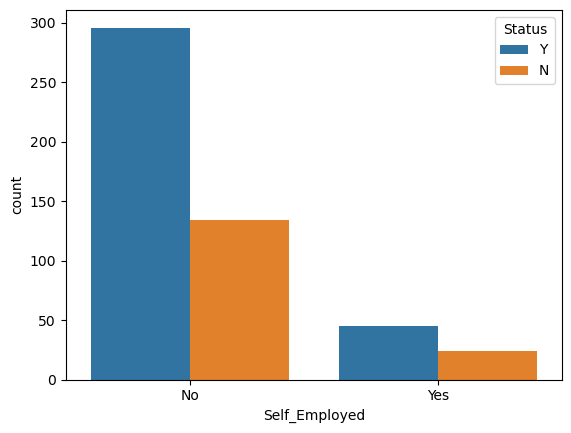

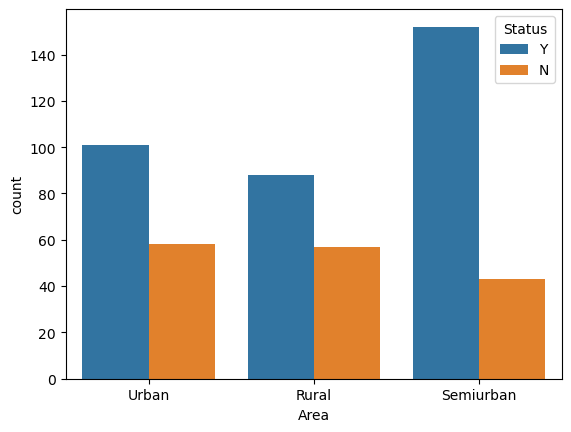

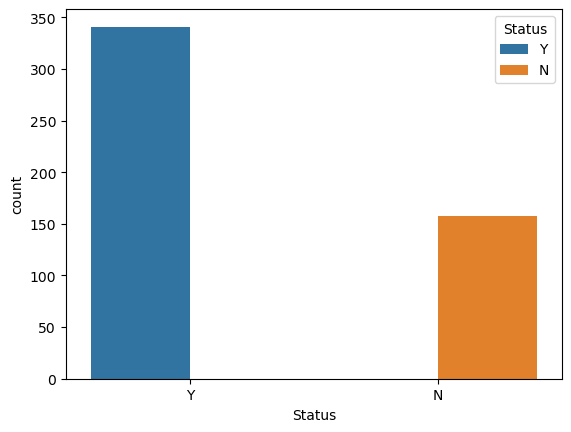

In [26]:
numeric = []
for i in loan_df.columns:
    if loan_df[i].dtypes =='O':
        sns.countplot(x=i, hue='Status', data=loan_df)
        plt.show()

In [154]:
categorical_columns = [loan_df[i].name for i in loan_df.columns if loan_df
                      [i].dtype=='object']

for i in loan_df.columns:
    if i in categorical_columns:
        print(loan_df[i].value_counts())

Male      411
Female     88
Name: Gender, dtype: int64
Yes    324
No     175
Name: Married, dtype: int64
0     284
2      88
1      84
3+     43
Name: Dependents, dtype: int64
Graduate        395
Not Graduate    104
Name: Education, dtype: int64
No     430
Yes     69
Name: Self_Employed, dtype: int64
Semiurban    195
Urban        159
Rural        145
Name: Area, dtype: int64
Y    341
N    158
Name: Status, dtype: int64


In [155]:
#categorical variable % rates in original data
for i in loan_df.columns:
    if i in categorical_columns:
        print((loan_df[i].value_counts())/len(loan_df)*100)

Male      82.364729
Female    17.635271
Name: Gender, dtype: float64
Yes    64.92986
No     35.07014
Name: Married, dtype: float64
0     56.913828
2     17.635271
1     16.833667
3+     8.617234
Name: Dependents, dtype: float64
Graduate        79.158317
Not Graduate    20.841683
Name: Education, dtype: float64
No     86.172345
Yes    13.827655
Name: Self_Employed, dtype: float64
Semiurban    39.078156
Urban        31.863727
Rural        29.058116
Name: Area, dtype: float64
Y    68.336673
N    31.663327
Name: Status, dtype: float64


In [156]:
# categorical variables % rates in cleaned data
for i in loan_encoded.columns:
    if i in categorical_columns:
        print((loan_encoded[i].value_counts())/len(loan_encoded)*100)
    

0    56.913828
2    17.635271
1    16.833667
3     8.617234
Name: Dependents, dtype: float64
1    82.364729
0    17.635271
Name: Gender, dtype: float64
1    64.92986
0    35.07014
Name: Married, dtype: float64
0    79.158317
1    20.841683
Name: Education, dtype: float64
0    86.172345
1    13.827655
Name: Self_Employed, dtype: float64
1    68.336673
0    31.663327
Name: Status, dtype: float64


In [157]:
loan_encoded.groupby(['Status']).agg('mean')

,Dependents,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area_Rural,Area_Semiurban,Area_Urban,Gender,Married,Education,Self_Employed
Status,,,,,,,,,,,,,
0,0.746835,570362.025316,172811.392405,1.436709e+07,341.620253,0.575949,0.360759,0.272152,0.367089,0.791139,0.575949,0.259494,0.151899
1,0.794721,516585.337243,149234.287387,1.376041e+07,342.193548,0.979472,0.258065,0.445748,0.296188,0.838710,0.683284,0.184751,0.131965


In [158]:
#Calculating the average income per gender
loan_encoded.pivot_table(index=['Gender', 'Status'], values='Applicant_Income', aggfunc=['mean', 'min', 'max'])

mean              min              max
              Applicant_Income Applicant_Income Applicant_Income
Gender Status                                                   
0      0         422451.515152           137800          1150000
       1         540310.909091            64500          1948400
1      0         609410.400000            15000          8100000
       1         512022.727273           102500          3999900

In [159]:
loan_encoded.pivot_table(index=['Gender', 'Status'], values='Loan_Amount', aggfunc=['mean', 'min', 'max'])

mean         min         max
                Loan_Amount Loan_Amount Loan_Amount
Gender Status                                      
0      0       1.189394e+07           0    28600000
       1       1.283091e+07           0    60000000
1      0       1.502000e+07           0    57000000
       1       1.393916e+07           0    60000000

<AxesSubplot:xlabel='Loan_Amount', ylabel='Applicant_Income'>

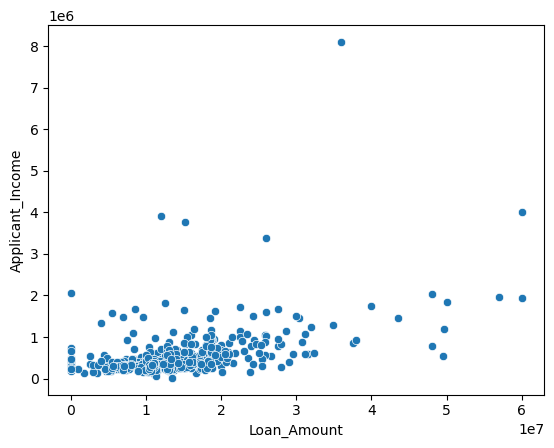

In [160]:
#Using a Scatterplot to show the loan Amount based on the Applicant's income level
sns.scatterplot(x=loan_encoded.Loan_Amount, y=loan_encoded.Applicant_Income)

<AxesSubplot:xlabel='Education', ylabel='Applicant_Income'>

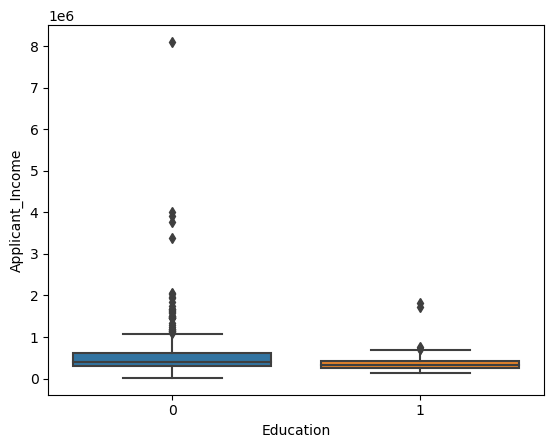

In [161]:
sns.boxplot(data=loan_encoded, x='Education', y='Applicant_Income')

<AxesSubplot:xlabel='Dependents', ylabel='Loan_Amount'>

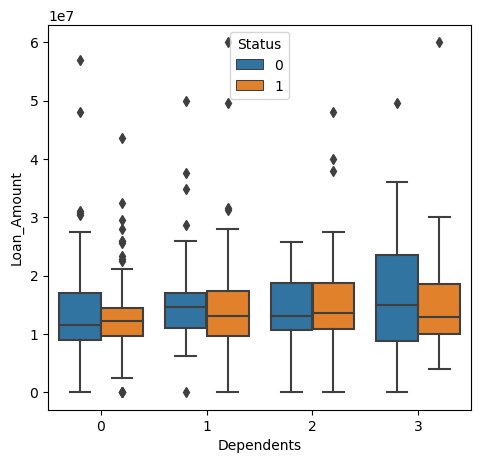

In [162]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.boxplot(data=loan_encoded, x='Dependents', y='Loan_Amount', hue='Status')

<AxesSubplot:xlabel='Dependents', ylabel='Applicant_Income'>

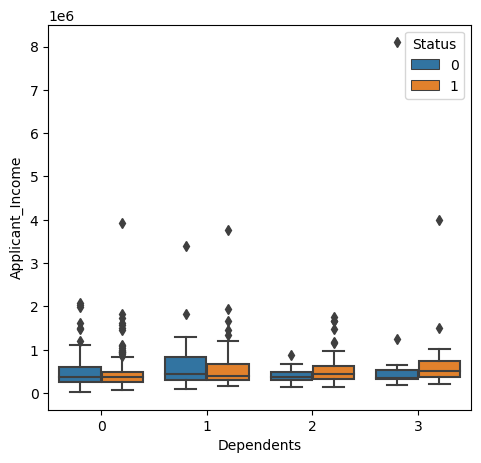

In [163]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.boxplot(data=loan_encoded, x='Dependents', y='Applicant_Income', hue='Status')

<AxesSubplot:xlabel='Dependents', ylabel='Loan_Amount'>

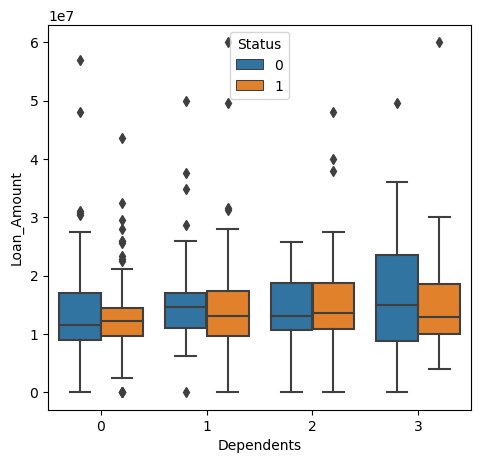

In [164]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.boxplot(data=loan_encoded, x='Dependents', y='Loan_Amount', hue='Status')

<AxesSubplot:xlabel='Self_Employed', ylabel='Applicant_Income'>

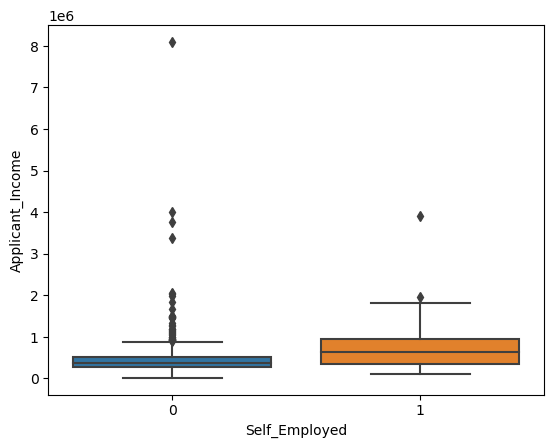

In [165]:
sns.boxplot(data=loan_encoded, x='Self_Employed', y='Applicant_Income')

## Modeling
In order to have consistent comparisions between all models used & be able to re-run them with consistent results, I set a random_state = 42. 

In [169]:
# Get labels for which class comes first in predictor class
pd.unique(y_train['Status_Y'])

array([0, 1], dtype=uint8)

### Linear Regression

In [170]:
X_train_lr = sm.add_constant(X_train)
X_test_lr = sm.add_constant(X_test)

In [171]:
# Fit the linear regression model
model = sm.OLS(y_train, X_train_lr, random_state = 42).fit()
# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Status_Y   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     9.660
Date:                Wed, 05 Apr 2023   Prob (F-statistic):           3.51e-16
Time:                        11:39:22   Log-Likelihood:                -167.50
No. Observations:                 349   AIC:                             361.0
Df Residuals:                     336   BIC:                             411.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [172]:
# Predict & get results for X_test
y_pred_lr = model.predict(X_test_lr)

print("Linear Regression MODEL:")
cm = confusion_matrix(y_test, y_pred_lr.round()) # We must round here because we get the predicted probability, not the actual class
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = model.predict(X_test_lr)
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

Linear Regression MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            32            25     57
Actual: 1             2            91     93
Total                34           116    150

Accuracy: 0.820
Sensitivity (Recall): 0.978
Specificity: 0.561
AUC score: 0.8292774948122995


### CART

In [173]:
# Fit a decision tree classifier to the training data
cart01 = DecisionTreeClassifier(criterion='gini', random_state=42).fit(X_train, y_train)

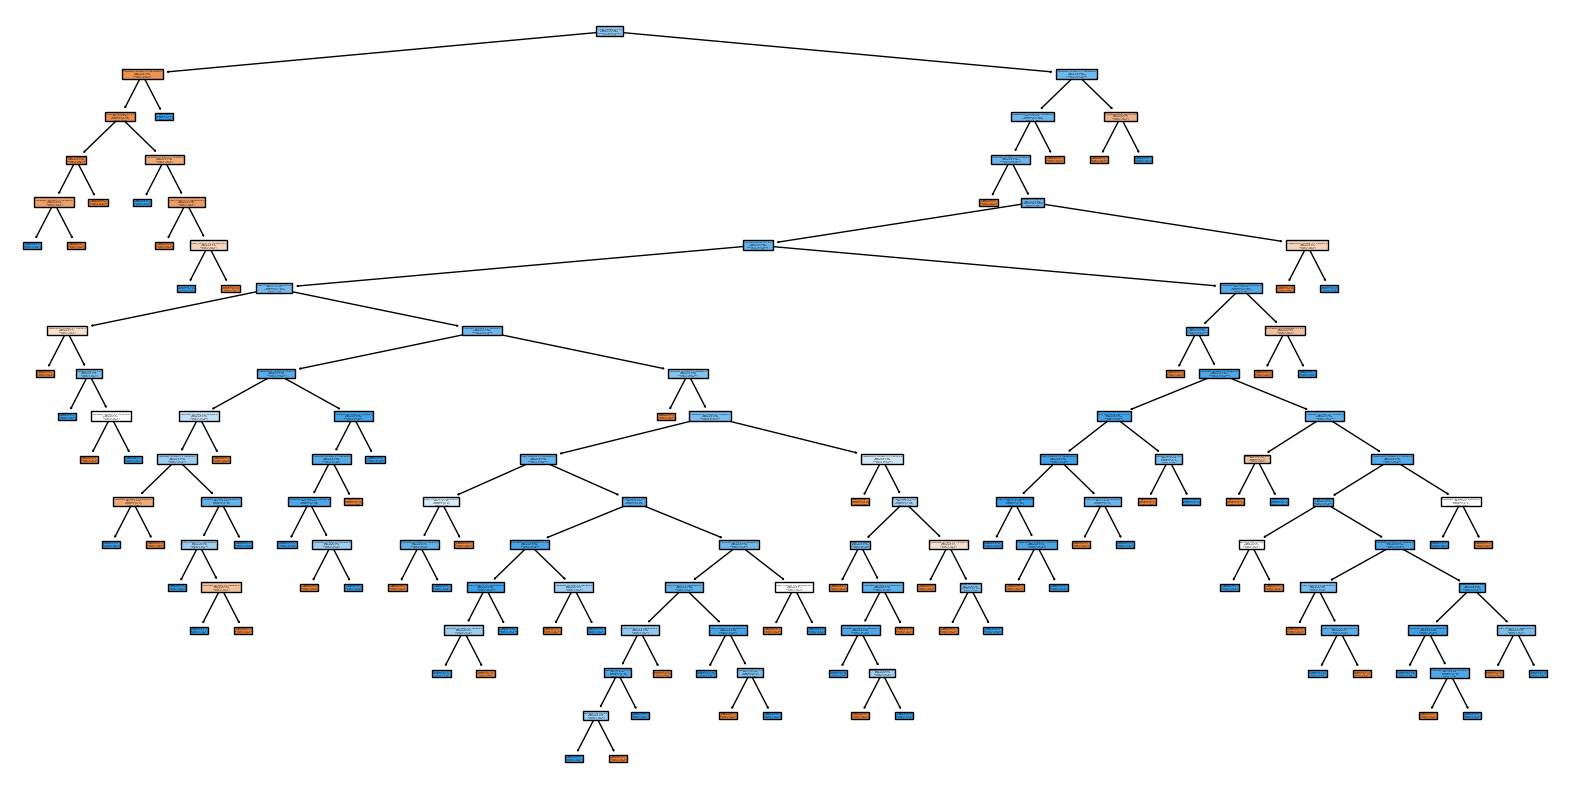

In [174]:
# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(cart01, feature_names=X_train.columns, class_names=['No', 'Yes'], filled=True)
plt.show()

In [175]:
# Predict & get results for X_test
y_pred_cart = cart01.predict(X_test)

print("CART MODEL:")
cm = confusion_matrix(y_test, y_pred_cart)
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = cart01.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

CART MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            37            20     57
Actual: 1            22            71     93
Total                59            91    150

Accuracy: 0.720
Sensitivity (Recall): 0.763
Specificity: 0.649
AUC score: 0.7062818336162988


#### Try with fewer variables & max_leaf_nodes = 5 for better visualization & to compare metrics

In [176]:
X_train_short = X_train[['Applicant_Income', 'Credit_History', 'Loan_Amount']]
X_test_short = X_test[['Applicant_Income', 'Credit_History', 'Loan_Amount']]

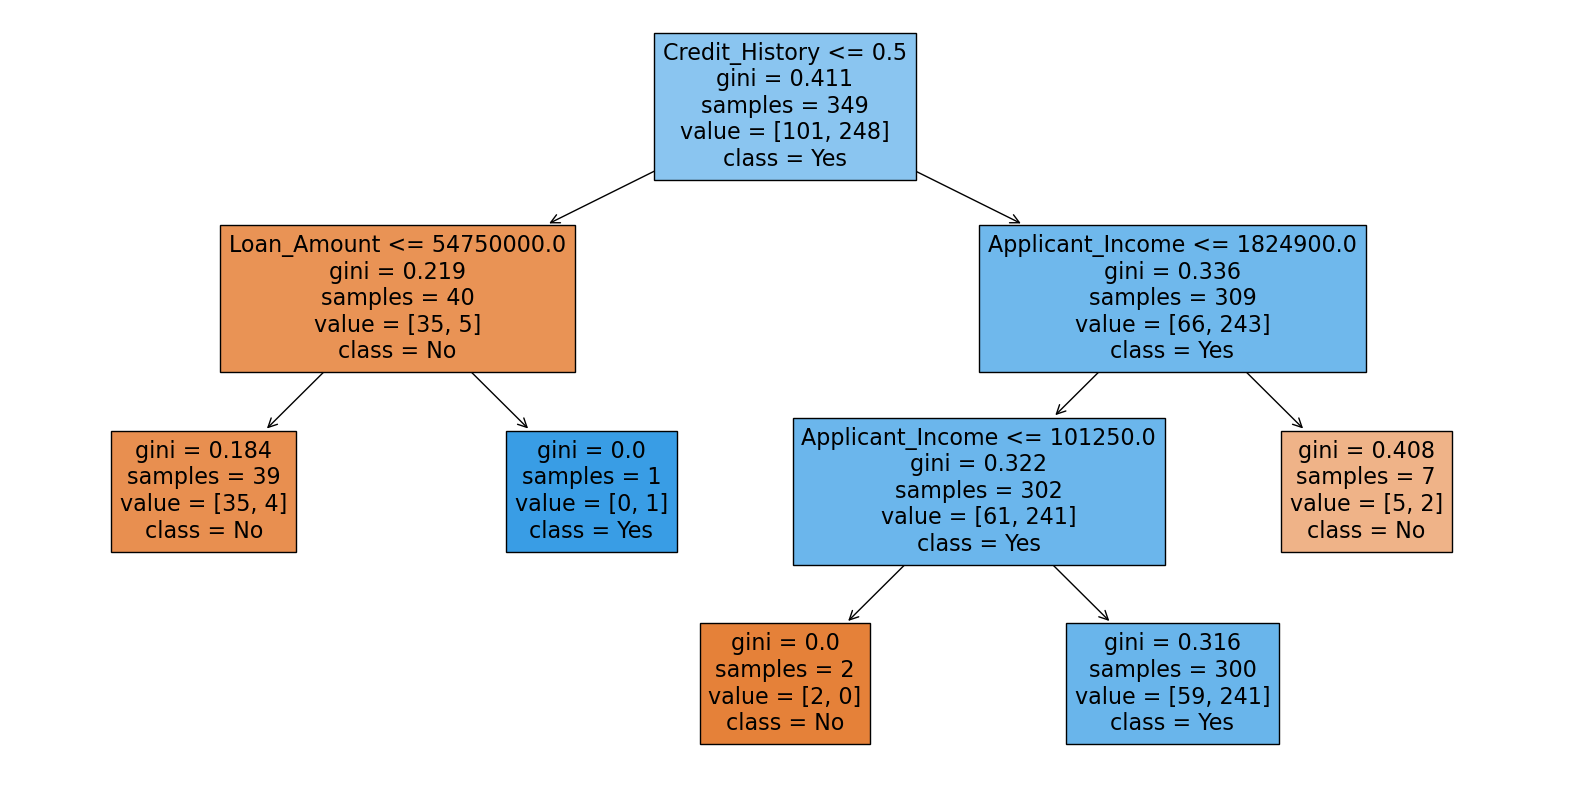

In [177]:
# Fit a decision tree classifier to the training data
cart02 = DecisionTreeClassifier(criterion='gini', max_leaf_nodes=5, random_state = 42).fit(X_train_short, y_train)

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(cart02, feature_names=X_train_short.columns, class_names=['No', 'Yes'], filled=True)
plt.show()

In [178]:
# Predict & get results for X_test
y_pred_cart_2 = cart02.predict(X_test_short)

print("CART MODEL:")
cm = confusion_matrix(y_test, y_pred_cart_2)
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = cart02.predict_proba(X_test_short)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

CART MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            32            25     57
Actual: 1             4            89     93
Total                36           114    150

Accuracy: 0.807
Sensitivity (Recall): 0.957
Specificity: 0.561
AUC score: 0.7591963780418789


### C5.0

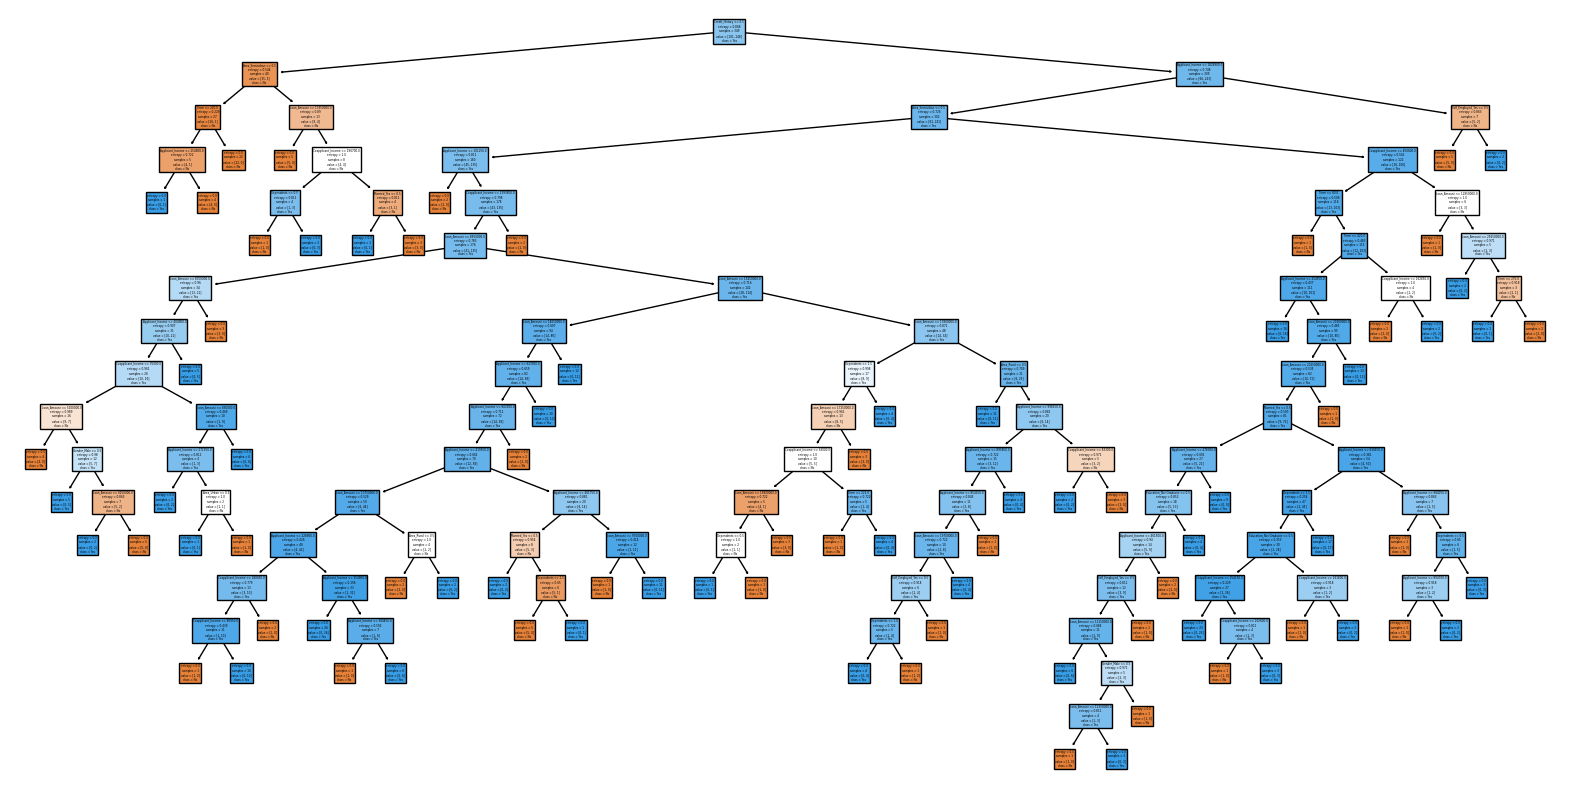

In [179]:
# Train on training dataset
c50_01 = DecisionTreeClassifier(criterion="entropy", random_state = 42).fit(X_train,y_train)

#Visualize the decision tree using the plot_tree function:
plt.figure(figsize=(20,10))
plot_tree(c50_01, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
plt.show()

In [180]:
# Predict & get results for X_test
y_pred_c50 = c50_01.predict(X_test)

print("C5.0 MODEL:")
cm = confusion_matrix(y_test, y_pred_c50)
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = c50_01.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

C5.0 MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            40            17     57
Actual: 1            22            71     93
Total                62            88    150

Accuracy: 0.740
Sensitivity (Recall): 0.763
Specificity: 0.702
AUC score: 0.732597623089983


### Random Forest

[Text(0.3543836805555556, 0.96875, 'Credit_History <= 0.5\ngini = 0.418\nsamples = 220\nvalue = [104, 245]\nclass = Yes'),
 Text(0.06944444444444445, 0.90625, 'Applicant_Income <= 2812450.0\ngini = 0.172\nsamples = 22\nvalue = [38, 4]\nclass = No'),
 Text(0.05555555555555555, 0.84375, 'Applicant_Income <= 215750.0\ngini = 0.136\nsamples = 21\nvalue = [38, 3]\nclass = No'),
 Text(0.027777777777777776, 0.78125, 'Applicant_Income <= 198350.0\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = No'),
 Text(0.013888888888888888, 0.71875, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = No'),
 Text(0.041666666666666664, 0.71875, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Yes'),
 Text(0.08333333333333333, 0.78125, 'Area_Semiurban <= 0.5\ngini = 0.097\nsamples = 19\nvalue = [37, 2]\nclass = No'),
 Text(0.06944444444444445, 0.71875, 'gini = 0.0\nsamples = 13\nvalue = [29, 0]\nclass = No'),
 Text(0.09722222222222222, 0.71875, 'Coapplicant_Income <= 125200.0\ngini = 0.32\nsamples = 6\nvalue 

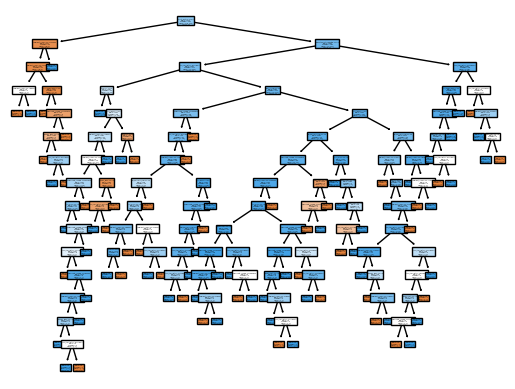

In [7]:
# Fit a random forest model to the data
rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 42).fit(X_train, y_train)

# Plot the first decision tree in the forest
plot_tree(rf.estimators_[0], feature_names=X_train.columns, class_names=['No', 'Yes'], filled=True)

In [8]:
# Predict & get results for X_test
y_pred_rf = rf.predict(X_test)

print("RANDOM FOREST MODEL:")
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = rf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

RANDOM FOREST MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            35            22     57
Actual: 1             7            86     93
Total                42           108    150

Accuracy: 0.807
Sensitivity (Recall): 0.925
Specificity: 0.614
AUC score: 0.8453122052442936


### Naive Bayes

In [183]:
# Flatted y_train into 1d array & fit NB model
y_train_1d = np.array(y_train).reshape(-1, 1)
nb = MultinomialNB().fit(X_train, y_train_1d)

# Predict & get results for X_test
y_pred_nb = nb.predict(X_test)

In [184]:
print("NAIVE BAYES MODEL:")
cm = confusion_matrix(y_test, y_pred_nb)
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = nb.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

NAIVE BAYES MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            21            36     57
Actual: 1            45            48     93
Total                66            84    150

Accuracy: 0.460
Sensitivity (Recall): 0.516
Specificity: 0.368
AUC score: 0.44623655913978494


## Model Optimization
Now that we are aware that the base Random Forest model with all possible features performs better than any other model, let's optimize it.

### Recursive Feature Elimination
Due to multicollinearity concerns, a model with less features may actually perform better than a model with more. Let's investigate it!

In [28]:
# Fit a random forest model to the data
rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)

# Loop over the number of features to select
for n_features in range(2, 14):
    # Create an RFE selector with step 1 and set the number of features to select
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=1)
    rfe.fit(X_train, y_train)

    # Keep only selected features & train on those
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    rf.fit(X_train_rfe, y_train)

    # generate predicted probabilities for the positive class of the target variable & ROC_AUC
    y_proba = rf.predict_proba(X_test_rfe)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)

    # Print the Features Selected & ROC AUC score
    features_selected = X_train.columns[rfe.support_]
    print(f'Number of features selected: {n_features}, Features selected: {features_selected}, ROC AUC score: {roc_auc:.4f}\n')

Number of features selected: 2, Features selected: Index(['Applicant_Income', 'Loan_Amount'], dtype='object'), ROC AUC score: 0.5518

Number of features selected: 3, Features selected: Index(['Applicant_Income', 'Loan_Amount', 'Credit_History'], dtype='object'), ROC AUC score: 0.8094

Number of features selected: 4, Features selected: Index(['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount',
       'Credit_History'],
      dtype='object'), ROC AUC score: 0.8098

Number of features selected: 5, Features selected: Index(['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term',
       'Credit_History'],
      dtype='object'), ROC AUC score: 0.8274

Number of features selected: 6, Features selected: Index(['Dependents', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount',
       'Term', 'Credit_History'],
      dtype='object'), ROC AUC score: 0.8331

Number of features selected: 7, Features selected: Index(['Dependents', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amo

Thus, we can determine that the most important features & those that will lead to the highest ROC AUC score are: 'Dependents', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term', 'Credit_History', 'Area_Rural', 'Area_Semiurban', 'Gender_Male', 'Married_Yes', 'Education_Not Graduate', 'Self_Employed_Yes'. We will use just those from here on out.

In [8]:
X_train_rfe = X_train[['Dependents', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term', 'Credit_History', 'Area_Rural', 'Area_Semiurban', 'Gender_Male', 'Married_Yes', 'Education_Not Graduate', 'Self_Employed_Yes']]
X_test_rfe = X_test[['Dependents', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term', 'Credit_History', 'Area_Rural', 'Area_Semiurban', 'Gender_Male', 'Married_Yes', 'Education_Not Graduate', 'Self_Employed_Yes']]

In [11]:
# Fit a random forest model to the data
rf2 = RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 42).fit(X_train_rfe, y_train)

# Predict & get results for X_test
y_pred_rf2 = rf2.predict(X_test_rfe)

print("RANDOM FOREST MODEL:")
cm = confusion_matrix(y_test, y_pred_rf2)
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = rf2.predict_proba(X_test_rfe)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

RANDOM FOREST MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            37            20     57
Actual: 1             7            86     93
Total                44           106    150

Accuracy: 0.820
Sensitivity (Recall): 0.925
Specificity: 0.649
AUC score: 0.8610639501980757


### Hyperparameter Optimization

In [12]:
# Get the original hyperparameters for a starting point
rf2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [9]:
# Set parameters to search through combinations of
param_grid = {
    'n_estimators': [30, 50, 100, 200],
    'min_samples_leaf': [1, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
}

# Initialize Random Forest Model & have grid_search iterate through all combinations of parameters
rf = RandomForestClassifier(criterion='gini', random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_rfe, y_train)

# Print the results for every hyperparameter combination
for i in range(len(grid_search.cv_results_['params'])):
    print('Hyperparameters:', grid_search.cv_results_['params'][i])
    print('ROC AUC score:', grid_search.cv_results_['mean_test_score'][i])

# Print the best hyperparameters & resulting ROC AUC score
print('\nBest hyperparameters:', grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict_proba(X_test_rfe)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC AUC score:', roc_auc)

Hyperparameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
ROC AUC score: 0.7176918367346938
Hyperparameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
ROC AUC score: 0.7176889212827987
Hyperparameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
ROC AUC score: 0.711718756073858
Hyperparameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
ROC AUC score: 0.7150457725947523
Hyperparameters: {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 30}
ROC AUC score: 0.7171835762876578
Hyperparameters: {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
ROC AUC score: 0.7170363459669582
Hyperparameters: {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
ROC AUC score: 0.726200583090379
Hyperparameters: {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
ROC AUC score: 0.7197078717201167
Hyperparameters: {'min_samples_leaf': 1, 'min_

### Get full metrics with the optimal hyperparameters & features
Important note: Even though the final hyperparamter-optimized model performs slightly worse than the original model with default hyperparameters, it is better to use the model that performed best during the cross-validation part of the GridSearchCV algorithm because it will be more generalizable to future data because, rather than just being tested on 1 test set (X_test), it was optimized by looking at 5 validation subsets within the training data. The resulting model still performs well on X_test (better than any other model type we tried). By using optimal hyperparameters obtained from cross-validation, we will have a stronger model that's more generalizable to all data. If we had tuned our hyperparamters on which resulted in the best performance on X_test, we would be overfitting it to the test set and it would have less applicability for future test sets.

In [10]:
# Predict & get results for X_test
y_pred_rf = best_rf.predict(X_test_rfe)

print("OPTIMIZED RANDOM FOREST MODEL:")
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])
cm_df.loc['Total'] = cm_df.sum()
cm_df['Total'] = cm_df.sum(axis=1)
print(cm_df)

# Compute metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 1] + cm[0, 0])

# Print results
print("\nAccuracy: {:.3f}".format(accuracy))
print("Sensitivity (Recall): {:.3f}".format(sensitivity))
print("Specificity: {:.3f}".format(specificity))

# Get AUC Score
# generate predicted probabilities for the positive class of the target variable
y_pred_proba = best_rf.predict_proba(X_test_rfe)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)

OPTIMIZED RANDOM FOREST MODEL:
           Predicted: 0  Predicted: 1  Total
Actual: 0            34            23     57
Actual: 1             6            87     93
Total                40           110    150

Accuracy: 0.807
Sensitivity (Recall): 0.935
Specificity: 0.596
AUC score: 0.8422939068100359


In [21]:
# See how the model performs at each classification threshold
# Create list of thresholds
thresholds = np.arange(0, 1.1, 0.1)
# Loop through thresholds and calculate TP, FP, TN, FN at each
results = {'threshold': [], 'TP': [], 'FP': [], 'TN': [], 'FN': []}
for thresh in thresholds:
    y_pred = y_pred_proba >= thresh
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    results['threshold'].append(thresh)
    results['TP'].append(tp)
    results['FP'].append(fp)
    results['TN'].append(tn)
    results['FN'].append(fn)

# Create a df with the results
results_df = pd.DataFrame(results)
results_df.set_index('threshold', inplace=True)
results_df.head(11)

,TP,FP,TN,FN
threshold,,,,
0.0,93,57,0,0
0.1,93,54,3,0
0.2,91,43,14,2
0.3,91,33,24,2
0.4,91,25,32,2
0.5,87,23,34,6
0.6,84,18,39,9
0.7,67,11,46,26
0.8,34,3,54,59


[Text(0.6134259259259259, 0.9666666666666667, 'Coapplicant_Income <= 431700.0\ngini = 0.418\nsamples = 220\nvalue = [104, 245]\nclass = Yes'),
 Text(0.33796296296296297, 0.9, 'Credit_History <= 0.5\ngini = 0.399\nsamples = 207\nvalue = [90, 237]\nclass = Yes'),
 Text(0.14814814814814814, 0.8333333333333334, 'Applicant_Income <= 2812450.0\ngini = 0.142\nsamples = 20\nvalue = [36, 3]\nclass = No'),
 Text(0.1111111111111111, 0.7666666666666667, 'Area_Rural <= 0.5\ngini = 0.1\nsamples = 19\nvalue = [36, 2]\nclass = No'),
 Text(0.07407407407407407, 0.7, 'Dependents <= 1.5\ngini = 0.153\nsamples = 14\nvalue = [22, 2]\nclass = No'),
 Text(0.037037037037037035, 0.6333333333333333, 'gini = 0.0\nsamples = 9\nvalue = [18, 0]\nclass = No'),
 Text(0.1111111111111111, 0.6333333333333333, 'gini = 0.444\nsamples = 5\nvalue = [4, 2]\nclass = No'),
 Text(0.14814814814814814, 0.7, 'gini = 0.0\nsamples = 5\nvalue = [14, 0]\nclass = No'),
 Text(0.18518518518518517, 0.7666666666666667, 'gini = 0.0\nsamples 

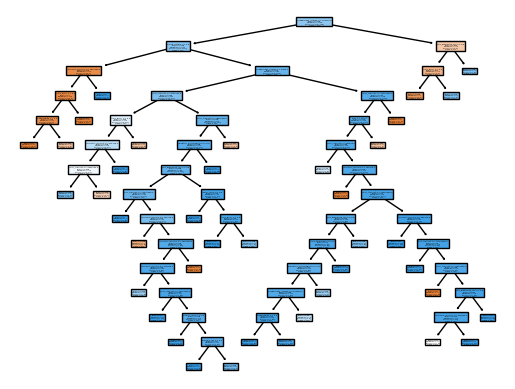

In [27]:
# Plot the first decision tree in the forest
plot_tree(best_rf.estimators_[0], feature_names=X_train_rfe.columns, class_names=['No', 'Yes'], filled=True)

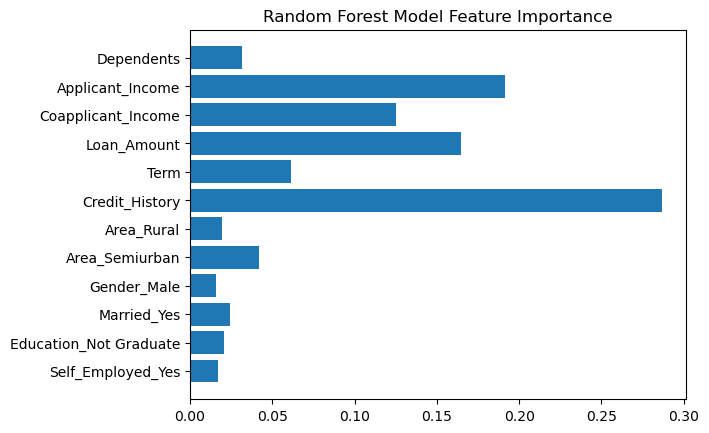

In [20]:
# Plot feature importance
# Get & sort feature importances
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
indices = [i for i in range(X_train_rfe.shape[1]) if i in indices]

# Get feature names & sort feature names
feature_names = list(X_train_rfe.columns)
feature_names = [feature_names[i] for i in indices]

# Format plot
plt.figure()
plt.title("Random Forest Model Feature Importance")
plt.barh(range(X_train_rfe.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train_rfe.shape[1]), feature_names)
plt.gca().invert_yaxis()
plt.show()